<a href="https://colab.research.google.com/github/popogeee/100Day_ML/blob/master/%E5%8F%B0%E8%82%A1%E6%8C%87%E6%95%B8LSTM_prediction_many_to_one.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [ ]:
df = pd.read_csv('test1.csv')

In [ ]:
#這邊的test1.csv是台股指數30分鐘取值後的檔案
#台股指數每30分鐘取一個平均值
#df = df[(df["台股指數"].index >= bottom) & (df["台股指數"].index <= ceil)].resample("30T").mean()

In [ ]:
df["date"] = pd.to_datetime(df["date"])

In [ ]:
df.set_index("date", drop=True, inplace=True)

In [ ]:
df = df.dropna()

In [ ]:
#將時間限制在2016-01-04 to 2020-08-13
bottom = datetime.datetime(2016,1,4)
ceil = datetime.datetime(2020,8,13)
train = datetime.datetime(2020,7,17)
test = datetime.datetime(2020,4,21)

In [ ]:
df_train = df[df.index <= train]  #訓練集2016-01-04 to 2020-07-17
df_test = df[df.index > test]  #測試集2020-04-22 to 2020-08-13
print(df_train.shape)
print(df_test.shape)

(11070, 1)
(800, 1)


In [ ]:
#建立training set, 有一對一，多對一，多對多不同預測方式
from sklearn.preprocessing import MinMaxScaler

training_set = df_train.values       
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

X_train = []   #預測點的前 60 天的資料
y_train = []   #預測點

for i in range(150, 11070):  # 11070 是訓練集總數(去掉NaN)
    X_train.append(training_set_scaled[i-150:i, 0]) #以120個數字為一組，每次加一往右遞增
    y_train.append(training_set_scaled[i, 0])      #以120個數字學習下一個數字(no.121)
X_train, y_train = np.array(X_train), np.array(y_train)  # 轉成numpy array的格式，以利輸入 RNN

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

#建立test set
real_stock_price = df_test.values
inputs = sc.fit_transform(real_stock_price)

X_test = []

for i in range(150, 800):  
    X_test.append(inputs[i-150:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))  # Reshape 成 3-dimension

In [ ]:
# Import the Keras libraries and packages
from tensorflow.keras import Sequential, optimizers
from tensorflow.keras.layers import Dense, LSTM, Dropout

# Initialising the RNN
regressor = Sequential()
# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 512, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.4))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 256, return_sequences = True))
regressor.add(Dropout(0.4))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 128, return_sequences = True))
regressor.add(Dropout(0.4))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 64))
regressor.add(Dropout(0.4))

# Adding the output layer
regressor.add(Dense(units = 1))

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
callbacks_list = [ModelCheckpoint(filepath='test1.hdf5', save_best_only=True)]
# Compiling
from tensorflow.keras import optimizers

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
# 進行訓練
history = regressor.fit(X_train,  y_train, batch_size=64, epochs=100, validation_split=0.2, callbacks=callbacks_list)

Epoch 1/100
137/137 [==============================] - 11s 77ms/step - loss: 0.0200 - val_loss: 0.0012
Epoch 2/100
137/137 [==============================] - 9s 69ms/step - loss: 0.0045 - val_loss: 0.0031
Epoch 3/100
137/137 [==============================] - 10s 70ms/step - loss: 0.0039 - val_loss: 0.0011
Epoch 4/100
137/137 [==============================] - 10s 70ms/step - loss: 0.0035 - val_loss: 7.9366e-04
Epoch 5/100
137/137 [==============================] - 9s 69ms/step - loss: 0.0032 - val_loss: 0.0022
Epoch 6/100
137/137 [==============================] - 10s 69ms/step - loss: 0.0030 - val_loss: 0.0015
Epoch 7/100
137/137 [==============================] - 10s 70ms/step - loss: 0.0027 - val_loss: 7.7232e-04
Epoch 8/100
137/137 [==============================] - 10s 70ms/step - loss: 0.0024 - val_loss: 6.5916e-04
Epoch 9/100
137/137 [==============================] - 10s 69ms/step - loss: 0.0022 - val_loss: 6.7370e-04
Epoch 10/100
137/137 [==============================] - 10s

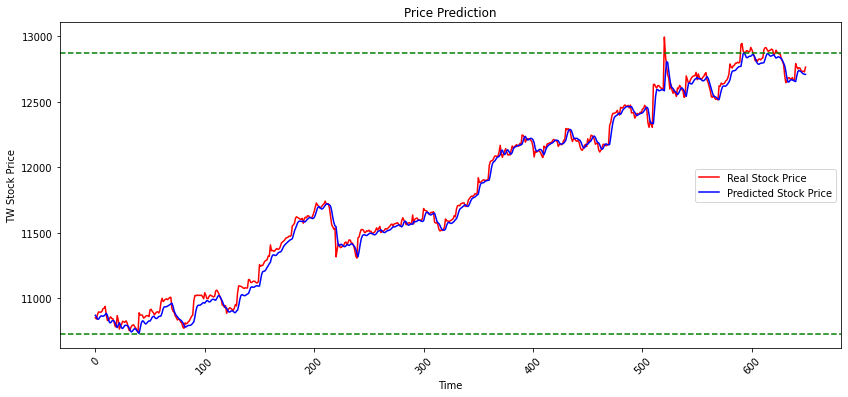

In [ ]:
#load best model
from tensorflow.keras.models import load_model

regressor = load_model('test.hdf5')
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

# Visualising the results
plt.figure(figsize=(14,6))
plt.plot(real_stock_price[-650:], color = 'red', label = 'Real Stock Price')  # 紅線表示真實股價
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')  # 藍線表示預測股價

plt.title('Price Prediction')
plt.axhline(predicted_stock_price.min(), linestyle='--', color= 'g')
plt.axhline(predicted_stock_price.max(), linestyle='--', color= 'g')
plt.xlabel('Time')
plt.ylabel('TW Stock Price')

plt.legend()
plt.xticks(rotation=45)
plt.show()

In [ ]:
date = df_test[-650:].index
real = real_stock_price[-650:]
after_prediction = predicted_stock_price

In [ ]:
after_df = pd.DataFrame(index=date, data={'real':real.reshape(650,), 'prediction':after_prediction.reshape(650,)})
after_df 

,real,prediction
date,,
2020-05-13 09:00:00,10852.671556,10871.030273
2020-05-13 09:30:00,10842.555000,10858.024414
2020-05-13 10:00:00,10877.796778,10841.174805
2020-05-13 10:30:00,10896.618694,10841.395508
2020-05-13 11:00:00,10894.089611,10854.939453
...,...,...
2020-08-13 11:30:00,12733.944444,12727.255859
2020-08-13 12:00:00,12730.004222,12718.530273
2020-08-13 12:30:00,12732.148750,12711.313477


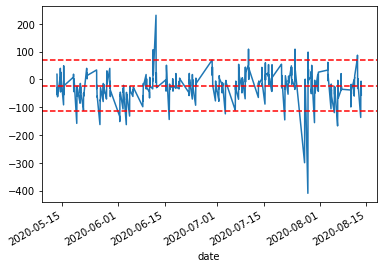

In [ ]:
#2SD是prediction price的上下限
after_df['delta'] = after_df["prediction"] - after_df["real"]
after_df["delta"].plot()
plt.axhline(after_df["delta"].mean(), linestyle='--', color= 'r')
plt.axhline(after_df["delta"].mean()-after_df["delta"].std()*2, linestyle='--', color= 'r')
plt.axhline(after_df["delta"].mean()+after_df["delta"].std()*2, linestyle='--', color= 'r')
plt.show()

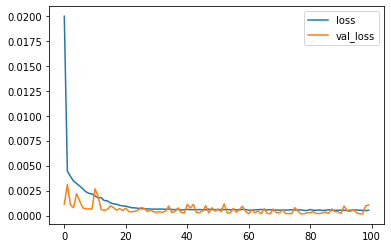

In [ ]:
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import r2_score
r2_score(real, after_prediction)

0.9939597255054848

In [ ]:
#1 0.9677716447648803
#2 0.9939597255054848 span from 120 increase to 150, batch_size from 120 decrease to 64

In [ ]:
new = pd.read_csv('for_prediction.csv')
new.drop('Unnamed: 0', inplace=True, axis=1)
new_150 = new.iloc[-150:]
new_150.set_index("date", drop=True, inplace=True)
new_150.tail()

,台股指數
date,
2020-08-18 11:30:00,12901.155417
2020-08-18 12:00:00,12909.589917
2020-08-18 12:30:00,12898.279111
2020-08-18 13:00:00,12896.715417
2020-08-18 13:30:00,12872.140000


In [ ]:
#建立prediction set
nearby_price = new_150.values

inputs = sc.fit_transform(nearby_price)

X_test = []

for i in range(150, 151):  
    X_test.append(inputs[i-150:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))  # Reshape 成 3-dimension
regressor = load_model('test.hdf5')
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [ ]:
predicted_stock_price

array([[12885.163]], dtype=float32)

In [ ]:
sc = MinMaxScaler(feature_range = (0, 1))
nearby_price = new_150.values
predictions = []
for j in range(9):    
    nearby_price = nearby_price.reshape(150,1)
    inputs = sc.fit_transform(nearby_price)
    X_test = []
    for i in range(150, 151):  
        X_test.append(inputs[i-150:i, 0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))  # Reshape 成 3-dimension
    regressor = load_model('test.hdf5')
    predicted_stock_price = regressor.predict(X_test)
    predicted_stock_price = sc.inverse_transform(predicted_stock_price)
    predictions.append(predicted_stock_price)
    nearby_price = np.append(nearby_price[-149:], predicted_stock_price)

In [ ]:
lists = []
for i in range(9):
    g = predictions[i][0][0]
    lists.append(g)
lists

[12885.163,
 12879.369,
 12878.658,
 12879.696,
 12880.562,
 12880.742,
 12880.424,
 12879.91,
 12879.387]